# Figure 5 - spatial and temporal coupling

In [3]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

# from collections import defaultdict

import h5py

# import cortex
import numpy as np

# import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from surfplot import Plot

from scipy.spatial.distance import cdist

from util import plot, subject
from util.path import Path
from util.atlas import Atlas  # , get_brainmask
from constants import SUBS_STRANGERS

# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('figures.mplstyle')

In [4]:
%cd ..

/scratch/gpfs/zzada/fconv


In [6]:
modelname = "model-gpt2-2b_layer-24"

features = ["task", "spectral", "articulation", "prod-LLM", "comp-LLM"]

encmodel = "encoding_trialmot6"
cache = encmodel.split("_")[-1]

modelname, encmodel, cache

('model-gpt2-2b_layer-24', 'encoding_trialmot6', 'trialmot6')

In [7]:
cachedir = f"cache/figure-mbc-lags/{modelname}/{cache}"
!mkdir -p $cachedir

In [8]:
catlas = Atlas.load("custom_glasser_group")
len(catlas)

22

In [9]:
lags = np.arange(-10, 11)
lags * 1.5

array([-15. , -13.5, -12. , -10.5,  -9. ,  -7.5,  -6. ,  -4.5,  -3. ,
        -1.5,   0. ,   1.5,   3. ,   4.5,   6. ,   7.5,   9. ,  10.5,
        12. ,  13.5,  15. ])

In [137]:
# subA prod pred -> subB comp actual
# by first shifting the signal, then taking out production time points, then correlating

sub_mbc_scores = []

# use subA's predictions on subB's actual neural data
for subA in tqdm(SUBS_STRANGERS):
    # load subA preds
    encpath = Path(root=encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        predA = f["cv_preds"][:, -2].reshape(1200, -1)
        prodmaskA = f["cv_prodmask"][...].ravel()

    # load subB preds
    subB = subject.get_partner(subA)
    encpath = Path(root=encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        nuis_predsB = f["cv_preds"][:, :-2].sum(1).reshape(1200, -1)
    dataB = subject.get_bold(subB, use_cache=True, cache_desc=cache)
    resB = dataB - nuis_predsB

    predA = catlas.vox_to_parc(predA)
    resB = catlas.vox_to_parc(resB)

    sub_scores = np.zeros((10, len(lags), len(catlas), len(catlas)), dtype=np.float32)
    for k, t in enumerate(range(0, 1200, 120)):
        trial_slice = slice(t, t+120) 
        predA_trial = predA[trial_slice]
        resB_trial = resB[trial_slice]

        for i, lag in enumerate(lags):
            if lag < 0:
                trialA = predA_trial[:lag]
                trialB = resB_trial[-lag:]
                trialM = prodmaskA[trial_slice][:lag]
            elif lag > 0:
                trialA = predA_trial[lag:]
                trialB = resB_trial[:-lag]
                trialM = prodmaskA[trial_slice][lag:]
            else:
                trialA = predA_trial
                trialB = resB_trial
                trialM = prodmaskA[trial_slice]

            x = trialA[trialM]
            y = trialB[trialM]

            sub_scores[k, i] = cdist(x.T, y.T, metric='correlation')

    sub_mbc_scores.append(sub_scores)

    # break

sub_mbc_prod = np.stack(sub_mbc_scores)
sub_mbc_prod.shape

 24%|██▍       | 14/58 [01:03<02:59,  4.08s/it]/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/scipy/spatial/distance.py:152: RuntimeWarning: Mean of empty slice.
  XA = XA - XA.mean(axis=1, keepdims=True)
/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/scipy/spatial/distance.py:153: RuntimeWarning: Mean of empty slice.
  XB = XB - XB.mean(axis=1, keepdims=True)
100%|██████████| 58/58 [04:16<00:00,  4.43s/it]


(58, 10, 21, 22, 22)

In [155]:
# save
with h5py.File(f"{cachedir}/mbc-prod_pred-actual-trial.hdf5", "w") as f:
    f.create_dataset(name="sub_mbc_prod", data=sub_mbc_prod)

In [10]:
# read
with h5py.File(f"{cachedir}/mbc-prod_pred-actual.hdf5", "r") as f:
    sub_mbc_prod = f["sub_mbc_prod"][...]
sub_mbc_prod.shape

(58, 5, 21, 22, 22)

# plot

In [11]:
sub_mbc_prod = np.nan_to_num(sub_mbc_prod, copy=False)

In [12]:
avg_mbc = (1 - sub_mbc_prod).mean((0,1))
avg_mbc.shape

(21, 22, 22)

In [13]:
hemi = 'RH'
seed = 'LangT'
networks = [['AUD', 'LangT', 'LangPT'], ['LangMFG', 'LangF', 'DMN']]

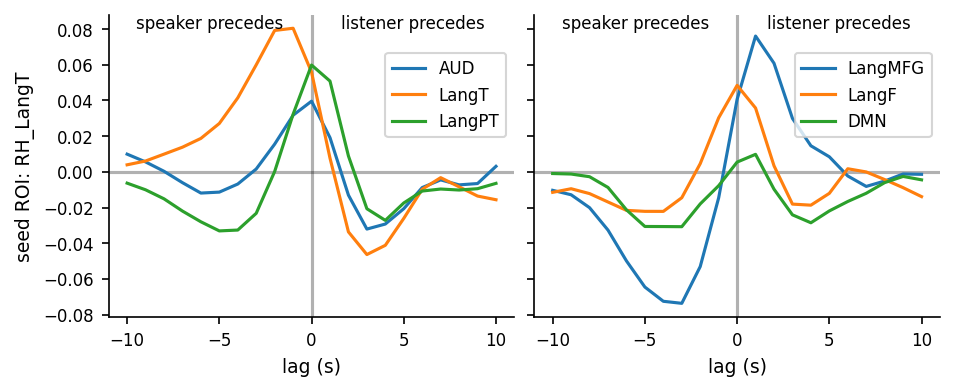

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(6.25, 2.5), sharex=True, sharey=True, layout='constrained')

seedROI = f'{hemi}_{seed}'
seedId = catlas[seedROI] - 1

for ax, nets in zip(axes, networks):
    ax.axvline(0, c="k", alpha=0.3)
    ax.axhline(0, c="k", alpha=0.3)

    for net in nets:
        targetROI = f'{hemi}_{net}'
        targetid = catlas[targetROI] - 1
        values = avg_mbc[:, seedId, targetid]
        ax.plot(lags, values, label=net)
        # print(seedROI, seedId, targetROI, targetid)

    ax.text(0.25, 1, "speaker precedes", transform=ax.transAxes, verticalalignment="top", horizontalalignment="center", fontsize=8)
    ax.text(0.75, 1, "listener precedes", transform=ax.transAxes, verticalalignment="top", horizontalalignment="center", fontsize=8)
    ax.legend(frameon=True, loc='upper right', bbox_to_anchor=(1, 0.9))
    # ax.legend(frameon=True, loc='upper center', ncols=3, bbox_to_anchor=(0.5, -0.2))
    ax.set_xlabel('lag (s)')

axes[0].set_ylabel(f'seed ROI: {seedROI}')

fig.show()

In [98]:
seeds = ['RH_LangPT', 'RH_LangF', 'RH_DMN']

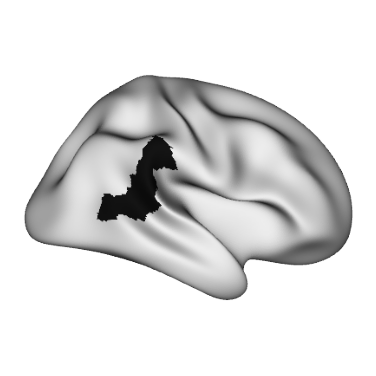

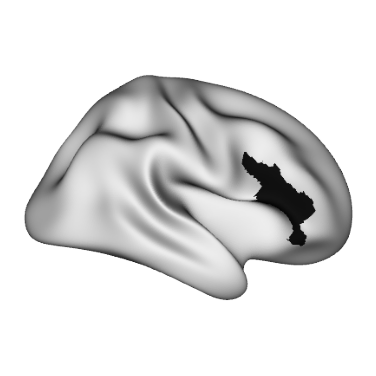

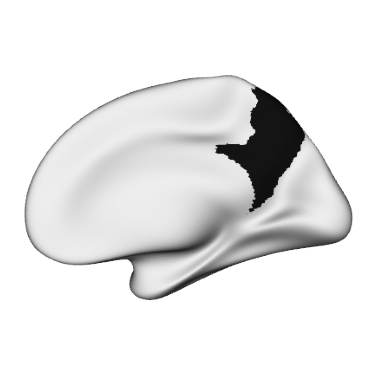

In [122]:
for seed in seeds:
    seedId = catlas[seed]
    roimask = catlas.roimask([seedId]).astype(int)

    view = 'lateral'
    if 'LangS' in seed or 'DMN' in seed:
        view = 'medial'
    # print(seed, seedId, roimask.sum(), view)

    p = Plot(surf_rh="mats/suma-fsaverage6/rh.inf_120.gii", views=view, brightness=0.7, size=(200, 200), zoom=1.2)
    p.add_layer({'right': roimask[roimask.size//2:]}, cmap='Grays', color_range=(0, 1), cbar=False)
    fig = p.build()
    fig.show()